<h1>Grid Search</h1>

In [1]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error
from xgboost import plot_importance
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

<h3>A - Prepare for Grid Search</h3>

In [2]:
features_names = [
    'month-day',
    'month',
    'day_in_month',
    'adep', 
    'country_code_adep', 
    'ades', 
    'country_code_ades', 
    'aircraft_type', 
    'wtc', 
    'airline', 
    'flight_duration', 
    'taxiout_time', 
    'flown_distance', 
    'actual_offblock_time_hour', 
    'actual_offblock_time_minute', 
    'actual_offblock_time_hour_minute', 
    'arrival_time_hour', 
    'arrival_time_minute', 
    'arrival_time_hour_minute', 
    'latitude_median', 
    'longitude_median', 
    'altitude_mean', 
    'groundspeed_mean', 
    'track_mean', 
    'vertical_rate_mean', 
    'track_unwrapped_mean', 
    'u_component_of_wind_mean', 
    'v_component_of_wind_mean', 
    'temperature_mean', 
    'specific_humidity_mean'
]

target = 'tow'

In [3]:
challenge_set_with_trajectory = pd.read_csv('../../data/challenge_set_experiment_1.csv')

# Convert relevant columns to category dtype
categorical_columns = [
    'month-day', 'adep', 'country_code_adep', 'ades', 'country_code_ades',
    'aircraft_type', 'wtc', 'airline', 'actual_offblock_time_hour_minute', 'arrival_time_hour_minute'
]

for col in categorical_columns:
    challenge_set_with_trajectory[col] = challenge_set_with_trajectory[col].astype('category')
    
# Pick up features from dataset
features = challenge_set_with_trajectory[features_names]

# Pick up target from dataset
target = challenge_set_with_trajectory[target]

In [4]:
# Function to score model using Root Mean Square Error
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
    
# Create a scorer
rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Make cross validation strategy
cv_strategy = KFold(n_splits=3, shuffle=True, random_state=123)

# Function to print the best parameters and best RMSE score after tunning
def print_model_score(grid_search):
    print("Best Parameters:", grid_search.best_params_)
    print("\nBest Score (Root Mean Squared Error):", grid_search.best_score_)

<h3>B - Perform Grid Search Random Forest Regressor</h3>

In [5]:
param_grid = {
    'n_estimators': [1, 15, 30, 45, 60, 75, 90, 105],     # Number of trees
    'max_depth': [1, 2, 4, 6, 8, 10],                         # Maximum depth of a tree
    'learning_rate': [0.1, 0.2, 0.4, 0.6, 0.8, 1.0],          # Step size shrinkage used in updates
    'subsample': [0.1, 0.2, 0.4, 0.6, 0.8, 1.0],              # Subsample ratio of the training instance
    'colsample_bytree': [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]        # Subsample ratio of columns when constructing each tree
}

# Initialize the XGBoost regressor
model = xgb.XGBRegressor(
    tree_method='hist',      # Use hist or approx to support categorical data
    enable_categorical=True,  # Enable categorical handling if using version 1.5.0+
    objective='reg:squarederror', 
    random_state=42
)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=rmse_scorer,
    cv=cv_strategy,
    n_jobs=-1,  # Use all available cores
    verbose=2
)  # Print detailed progress

# Fit GridSearchCV
grid_search.fit(features, target)

# Print Grid Search Results
print_model_score(grid_search)

Fitting 3 folds for each of 10368 candidates, totalling 31104 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 105, 'subsample': 1.0}

Best Score (Root Mean Squared Error): -4027.3851584112526


<h3>D - Feature Importances</h3>

<Figure size 1000x800 with 0 Axes>

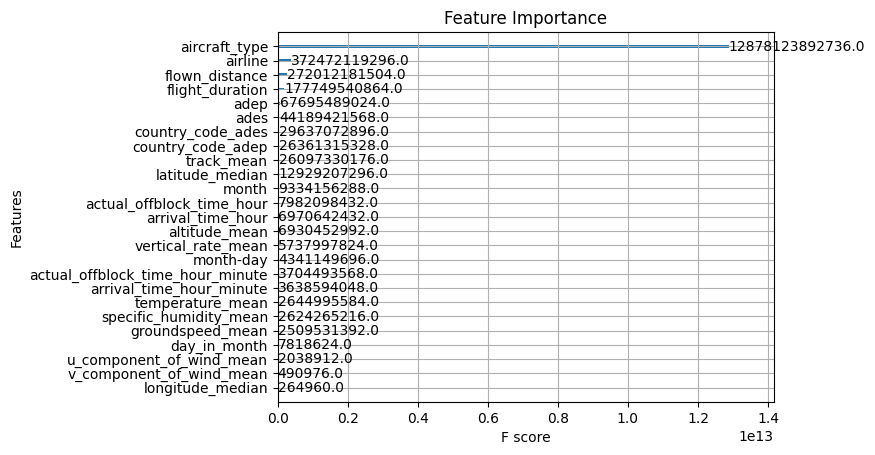

In [6]:
# Plot feature importance
best_model = grid_search.best_estimator_

plt.figure(figsize=(10, 8))
xgb.plot_importance(best_model, importance_type='gain')
plt.title('Feature Importance')
plt.show()